# Deep Deterministic Policy Gradients (DDPG)

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import gym
import random
import torch
import pickle
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from tensorboardX import SummaryWriter
from unityagents import UnityEnvironment
from agents.ddpg_agent import Agent
from agents.utils.RunConfig import RunConfig
from agents.utils.buffers import Experience
import seaborn as sns

In [2]:
def get_env(seed):
    from sys import platform as _platform
    if _platform == "linux" or _platform == "linux2":
       # linux
        env = UnityEnvironment(file_name="../unity_envs/Reacher_Linux/Reacher.x86_64", seed = seed)
    elif _platform == "darwin":
       # MAC OS X
       env = UnityEnvironment(file_name="../unity_envs/Reacher.app", no_graphics=False, seed = seed)
    return env

def get_train_env_multi(seed):
    from sys import platform as _platform
    if _platform == "linux" or _platform == "linux2":
       # linux
        env = UnityEnvironment(file_name="../unity_envs/Reacher_Linux_Multi/Reacher.x86_64", seed = seed)
    elif _platform == "darwin":
       # MAC OS X
       env = UnityEnvironment(file_name="../unity_envs/Reacher_Multi.app", no_graphics=False, seed = seed)
    return env

def welcome(seed, multi = True):
    # env = get_env()
    if multi:
        env = get_train_env_multi(seed)
    else:
        env = get_env(seed)

    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]

    # number of agents
    num_agents = len(env_info.agents)

    # size of each action
    action_size = brain.vector_action_space_size

    # examine the state space
    states = env_info.vector_observations
    state_size = states.shape[1]
    print('Number of agents:', num_agents)
    print('Size of each action:', action_size)
    print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

    return env, state_size, action_size, num_agents


In [3]:
def plot_data(data, title, color = 'b'):
    fig = plt.figure()
    sns.tsplot(data, color=color)
    plt.xlabel('Episode', fontsize = 16)
    plt.ylabel('Avg. Episodic Return', fontsize = 20)
    plt.title(title, fontsize=30)
    plt.show()


def plot_scores(data):
    train_scores = []
    eval_scores = []
    for k, v in data.items():
        train_score_i = v[0]
        eval_scores_i = v[1]
        train_score_i = np.mean(np.array(train_score_i), axis=1).tolist()
        eval_scores_i = np.mean(np.array(eval_scores_i), axis=1).tolist()
        train_scores.append(train_score_i)
        eval_scores.append(eval_scores_i)

    plot_data(train_scores, 'Train Scores', color='b')
    plot_data(train_scores, 'Eval Scores', color='r')

In [4]:
def save_model(agent, dir, prefix=''):
    import os
    if not os.path.exists(dir + prefix):
        os.makedirs(dir + prefix)

    torch.save(agent.actor_local.state_dict(), dir + prefix + 'actor.pth')
    torch.save(agent.critic_local.state_dict(), dir + prefix + 'critic.pth')

    return tuple([dir + prefix + net_name for net_name in ['critic.pth', 'actor.pth']])

In [5]:
def eval_ddpg(env, config):
    agent = config.eval_agent

    brain_name = env.brain_names[0]
    env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
    s = env_info.vector_observations  # get the current state (for each train_agent)
    num_agents = len(env_info.agents)
    G = np.zeros(num_agents)  # Undiscounted return for each train_agent

    t = 0
    while True:
        a = agent.act(s, add_noise = False)                 # select an action from train_agent
        env_info = env.step(a)[brain_name]                  # send all actions to tne environment
        sp = env_info.vector_observations                   # get next state (for each train_agent)
        r = np.array(env_info.rewards)                      # get reward (for each train_agent)
        dones = np.array(env_info.local_done)               # see if episode finished
        G += r                                              # update the score (for each train_agent)
        if np.any(dones):                                   # exit loop if episode finished
            break
        else:
            s = sp                                          # roll over states to next time step
            t += 1
    return G


In [6]:
def ddpg_train(env, config, n_episodes=2000, max_t=int(10000), prefix='', algo = 'ddpg'):
    scores_deque = deque(maxlen=100)
    undisc_G = []
    undisc_eval_G = []
    agent = config.train_agent
    episode_horizons = deque(maxlen=100)
    brain_name = env.brain_names[0]
    env_solved = False
    best_score = 0.

    for i_episode in range( n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        s = env_info.vector_observations
        n_agents = s.shape[0]
        agent.reset()
        score = np.zeros((n_agents, 1), dtype=np.float32)
        for t in range(max_t):
            a = agent.act(s)
            env_info = env.step(a)[brain_name]
            sp = env_info.vector_observations
            r = np.array(env_info.rewards)[..., None]
            done = np.array(env_info.local_done)[..., None]
            if t+1 == max_t:
                done = np.ones_like(done, dtype = np.bool)

            agent.step(Experience(s=s, a=a, r=r, sp=sp, done=done.astype(np.float32)))
            s = sp
            score += r
            if np.all(done):
                episode_horizons.append(t)
                break

        scores_deque.append(score)
        undisc_G.append(score)
        writer.add_scalar('score_G', np.mean(score), i_episode)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), float(np.mean(score))), end="")

        if i_episode % 50 == 0:
            print('') # Feed space

        if (np.mean(scores_deque) >= 30.) and (i_episode > 99) and (not env_solved):
            print('\n 100-avg score of 30 reached in {} episodes\n'.format(i_episode))
            env_solved = True

        if best_score < float(np.mean(undisc_G[i_episode])):
            best_score = np.mean(undisc_G[i_episode])
            print('\t- Mean episodic undiscounted return improved.')
            policy_path = save_model(agent, dir='../models/{}/'.format(algo), prefix=prefix)
            config.policy_dir = policy_path

        if (i_episode + 1) % 20 == 0:
            eval_G=eval_ddpg(env, config).squeeze()
            print('\tEval mean return: {:.2f}'.format(np.mean(eval_G)))
            undisc_eval_G.append(eval_G)

    return undisc_G, undisc_eval_G


#### Parameters

In [7]:
n_episodes = 1000
rollout = 1000
seed = 200

In [8]:
config = RunConfig()
config.batch_size = 64
config.rollout = rollout
config.replay_buffer_size = 1e6
config.discount = 0.99
config.eval_interval = 10
config.eval_episodes = 1
config.actor_grad_clip = None
config.critic_grad_clip = 1.

config.learn_repeat = 4
config.update_actor_interval = 2
config.update_actor_repeat = 1
config.update_critic_interval = 1
config.update_critic_repeat = 1

config.actor_lr = 1e-4
config.critic_lr = 1e-4
config.tau_pi = 1e-3
config.tau_q = 1e-3

config.exploration_steps = 1000
config.critic_weight_decay = 0 # 1.0e-2

config.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Instantiate the Environment

##### Instantiate Agent

In [9]:
env_name = 'reacher'
prefix = 'reacher/'
algo = 'ddpg'
log_dir = '../logs/{}/'.format(algo) + env_name + '/'
pickl_name = 'scores.pkl'

if not os.path.isdir(log_dir):
    os.makedirs(log_dir)

env, state_size, action_size, n_agents = welcome(seed)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33


In [10]:
writer = SummaryWriter(log_dir='../logs/{}/'.format(algo) + prefix)

agent = Agent(state_size=state_size,
                action_size=action_size,
                random_seed =seed,
                n_agents=n_agents,
                writer=writer,
                config=config)

config.train_agent = agent
config.eval_agent = agent

In [11]:
undisc_G, undisc_eval_G = ddpg_train(env, config, n_episodes=n_episodes, 
                                       max_t=rollout, prefix=prefix, algo=algo)

Episode 0	Average Score: 0.30	Score: 0.30
	- Mean episodic undiscounted return improved.
Episode 1	Average Score: 0.32	Score: 0.33	- Mean episodic undiscounted return improved.
Episode 2	Average Score: 0.67	Score: 1.37	- Mean episodic undiscounted return improved.
Episode 3	Average Score: 0.88	Score: 1.54	- Mean episodic undiscounted return improved.
Episode 4	Average Score: 1.05	Score: 1.72	- Mean episodic undiscounted return improved.
Episode 5	Average Score: 1.31	Score: 2.59	- Mean episodic undiscounted return improved.
Episode 6	Average Score: 1.64	Score: 3.64	- Mean episodic undiscounted return improved.
Episode 7	Average Score: 2.16	Score: 5.80	- Mean episodic undiscounted return improved.
Episode 8	Average Score: 2.76	Score: 7.53	- Mean episodic undiscounted return improved.
Episode 9	Average Score: 3.43	Score: 9.47	- Mean episodic undiscounted return improved.
Episode 10	Average Score: 4.31	Score: 13.11	- Mean episodic undiscounted return improved.
Episode 11	Average Score: 5.4

/home/gerti/miniconda3/envs/rl/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


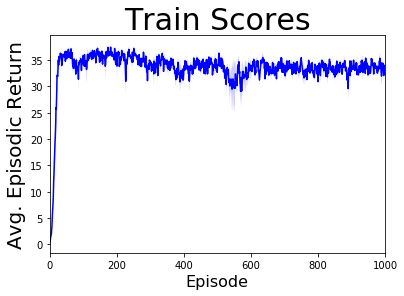

/home/gerti/miniconda3/envs/rl/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


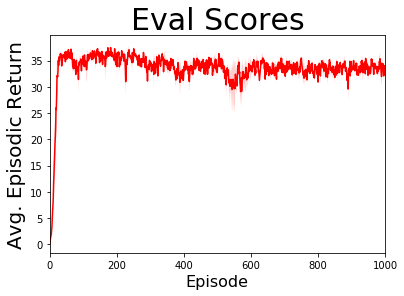

In [12]:
data = None
if os.path.isfile(os.path.join(log_dir, pickl_name)):
    with open(os.path.join(log_dir, pickl_name), mode='rb') as pf:
        data = pickle.load(pf)
        data[seed] = (undisc_G, undisc_eval_G)
    with open(os.path.join(log_dir, pickl_name), mode='wb') as pf:
        pickle.dump(data, pf)
else:
    with open(os.path.join(log_dir, pickl_name), mode='wb') as pf:
        pickle.dump({seed:(undisc_G, undisc_eval_G)}, pf)

if data is not None:
    plot_scores(data)
